In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from abc import ABC, abstractmethod
from collections import deque
#from pettingzoo.classic import tictactoe_v3
from typing import List

from mpl_toolkits.mplot3d import Axes3D
#import ipyvolume as ipv
from functools import reduce
import operator
import seaborn as sns
import pandas as pd
import pickle

from torch import autocast
from torch.distributions import Categorical
#from torchrl.envs.libs import pettingzoo

torch.set_default_dtype(torch.float)
if torch.cuda.is_available():
    print("CUDA IS TRUE", torch.get_autocast_gpu_dtype)
    torch.set_default_device('cuda')


class Environment:
    def __init__(self, size=(21, 21, 21), diff=1, risk_prob=0.1, death_prob=0.01):
        if torch.cuda.is_available():
          device = 'cuda'
        self.size = size  # Grid size, e.g., (100, 100, 100) for 3D
        self.vol = size[0] * size[1] * size[2]
        self.diff = diff  # A difficulty or variability factor
        self.dim = len(size)
        self.target = (0, 0, 0, 0)  # energy-p, wall-p, risk-p, death-p by volume or by cells, index by 0
        self.isRiskCluster = True

        # main game -> min (time(steps) * total_energy) -> compared with (l2_distance * harmonic_or_mean_or_70_or_max_energy). if agent_score < estimated_score, good. if a_s > e_s, improve. hm7m is param tightened by agent performance
        # minimize energy = main objective
        self.energy = torch.clamp(torch.normal(0.2, 0.5, size=self.size), min=0, max=3)
        # cannot transpose to wall, if slip into wall -> terminate , death ,-r
        self.wall = torch.zeros(size)
        # risk will lead to slip to a random neighbor cell
        self.risk = torch.mul(torch.rand(size), risk_prob)
        # if death will terminal state, negative reward (-r)
        self.death = torch.mul(self.risk, death_prob)

        self.init_properties()
        # map = not wall(death + energy * risk)) // Energy has been normalised to 0-1

        self.map = torch.add(
            torch.mul(
                (self.energy * (1 + self.risk) / self.energy.max()),
                torch.logical_not(self.wall)
            ),
            self.death)

    def set_diff(self):
        print(self.vol)
        if self.diff == 1:
            self.target = (1, self.vol * 0.1, 0.1, 0.01)
            print("Setting Diff: ", self.diff, " -> ", self.target)
            return

        if self.diff == 2:
            self.target = (1.2, self.vol * 0.2, 0.2, 0.05)
            print("Setting Diff: ", self.diff, " -> ", self.target)
            return

        if self.diff == 3:
            self.target = (2, self.vol * 0.3, 0.3, 0.1)
            print("Setting Diff: ", self.diff, " -> ", self.target)
            return

    def init_properties(self):
        # Initialize grids with normal distributions
        self.diff = np.random.randint(1, 4)
        self.set_diff()
        volume = reduce(operator.mul, self.size, 1)
        print("INIT: Volume", volume)
        print("INIT: target: ", self.target)
        mask_r = int(max(self.size) * 0.1)  # 70% limit of any dim

        def create_hot_tensor(shape, min_value, max_value):
            dims = len(shape)
            ranges = [torch.arange(s, dtype=torch.float16) - (s - 1) / 2.0 for s in shape]
            grid = torch.meshgrid(ranges, indexing='ij')
            dist_matrix = torch.stack([torch.abs(grid[dim]) for dim in range(dims)]).max(0).values
            steps = max((s - 1) / 2 for s in shape)
            increment = (max_value - min_value) / steps if steps != 0 else 0
            values = min_value + (steps - dist_matrix) * increment
            values = torch.clamp(values, min=min_value, max=max_value).int()  # Ensure values are within specified range
            return values

        def set_random_dim_to_one(size):
            return tuple(np.where(np.arange(len(size)) == np.random.randint(len(size)), 2, size))

        def apply_hot_region(tensor, center, size, min_value, max_value, mode):
            if mode == 0:
                hot_tensor = create_hot_tensor(size, min_value, max_value)
            elif mode == 1:
                size = set_random_dim_to_one(size)  # shrink size by x dim
                hot_tensor = torch.ones(size)

            # Calculate slice for each dimension for the parent tensor
            parent_slices = []
            hot_tensor_slices = []

            for c, s, es in zip(center, size, tensor.shape):
                # Start and end points for the slice on the parent tensor
                start = max(0, c - s // 2)
                end = min(c + (s + 1) // 2, es)

                # Corresponding start and end points on the hot_tensor
                hot_start = max(0, s // 2 - c if c < s // 2 else 0)
                hot_end = s - max(0, (c + (s + 1) // 2) - es)

                # Append the slices to the lists
                parent_slices.append(slice(start, end))
                hot_tensor_slices.append(slice(hot_start, hot_end))

            # Convert lists to tuples
            parent_slices = tuple(parent_slices)
            hot_tensor_slices = tuple(hot_tensor_slices)

            # Place the correctly sliced hot_tensor into the parent tensor
            tensor[parent_slices] = hot_tensor[hot_tensor_slices]
            return tensor

        def set_tensor_edges_to_one(tensor):
            """
            Sets the edges of an n-dimensional tensor to 1.

            Args:
            - tensor (torch.Tensor): An n-dimensional tensor.

            Returns:
            - torch.Tensor: The modified tensor with its edges set to 1.
            """
            # Iterate over each dimension and set the edge indices to 1
            for dim in range(tensor.ndim):
                # Get a list of all slice(None) initially which means select everything along each dimension
                indexer = [slice(None)] * tensor.ndim

                # Set the first and last index of the current dimension to 1
                indexer[dim] = 0
                tensor[tuple(indexer)] = 1
                indexer[dim] = -1
                tensor[tuple(indexer)] = 1

            return tensor

        def rand_center(tensor, r):
            # Ensure that the generated center is at least `r` away from the edges of the tensor
            return tuple(np.random.randint(low=r, high=dim - r) if dim > 2 * r else r for dim in tensor.shape)

        def tensor_vol(dim, vol):
            k = 1
            random_matrix = torch.clamp(torch.rand(dim), max=k)
            return tuple(torch.round(random_matrix * vol).int().tolist())

        print("INIT: Energy", self.energy.mean() > self.target[0])
        energy_flag = True
        i = 0
        while energy_flag:
            self.energy = apply_hot_region(
                self.energy,
                rand_center(self.energy, mask_r),
                tensor_vol(self.dim, self.vol * 0.003),
                0,
                3,
                mode=0
            )
            i += 1
            if (self.energy.mean() > self.target[0]) or (i == 50000):
                energy_flag = False
                print("if ", self.energy.mean() > self.target[0], " or ", (i == 50000), "flag: ", energy_flag)
                print("self.energy.mean: ", self.energy.mean())

        print("INIT: Wall", self.wall.sum() > (self.target[1]))
        wall_flag = True
        i = 0
        while wall_flag:
            self.wall = apply_hot_region(
                self.wall,
                rand_center(self.wall, mask_r),
                tensor_vol(self.dim, self.vol * 0.001),
                1,
                1,
                mode=1
            )
            i += 1
            if (self.wall.sum() > self.target[1]) or (i == 10000):
                wall_flag = False
                print("if ", self.wall.sum() > self.target[1], " or ", (i == 10000), "-> flag: ", wall_flag)
                self.wall = set_tensor_edges_to_one(self.wall.clone())
                self.wall = torch.bernoulli(self.wall)

        print("INIT: Risk", self.risk.mean() > (self.target[2]))
        risk_flag = True
        i = 0
        if self.isRiskCluster:
            while risk_flag:
                self.risk = apply_hot_region(
                    self.risk,
                    rand_center(self.risk, mask_r),
                    tensor_vol(self.dim, self.vol * 0.001),
                    1,
                    10,
                    mode=0
                )
                i += 1
                if (self.risk.mean() / 10 > self.target[2]) or (i == 10000):
                    risk_flag = False
                    print("if ", self.risk.mean() / 10 > self.target[2], " or ", (i == 10000), "flag: ", risk_flag)
                    self.risk = torch.mul(self.risk, 0.1)

        print("INIT: Death", self.risk.mean() * self.target[3])
        self.death = torch.bernoulli(torch.mul(self.risk, self.target[3]))

    def env_global_features(self, len=3):
        # Function to calculate feature sums for all axes
        def compress_nd_matrix_sum(data) -> torch.tensor:
            """
            Compress an n-dimensional matrix by summing along each axis using PyTorch.

            Parameters:
                data (torch.Tensor): An n-dimensional PyTorch tensor.
            """
            n_dimensions = data.ndim
            compressed_results = []
            for axis in range(n_dimensions):
                # Sum along the current axis and store the result
                axis_sum = torch.sum(data, dim=axis)
                compressed_results.append(axis_sum)
            return torch.stack(compressed_results)

        if len == 1:
            return torch.stack([compress_nd_matrix_sum(self.map.clone())
                                ])
        elif len == 2:
            return torch.stack([compress_nd_matrix_sum(self.map.clone()),
                                compress_nd_matrix_sum(self.wall.clone())
                                ])
        elif len == 3:
            return torch.stack([compress_nd_matrix_sum(self.energy.clone()),
                                compress_nd_matrix_sum(self.risk.clone()),
                                compress_nd_matrix_sum(self.wall.clone()),
                                ])
        elif len == 4:
            return torch.stack([compress_nd_matrix_sum(self.energy.clone()),
                                compress_nd_matrix_sum(self.risk.clone()),
                                compress_nd_matrix_sum(self.wall.clone()),
                                compress_nd_matrix_sum(self.death.clone())
                                ])
        elif len == 5:
            return torch.stack([compress_nd_matrix_sum(self.energy.clone()),
                                compress_nd_matrix_sum(self.risk.clone()),
                                compress_nd_matrix_sum(self.wall.clone()),
                                compress_nd_matrix_sum(self.death.clone()),
                                compress_nd_matrix_sum(self.map.clone())
                                ])

    def env_local_state(self, loc, len=3):
        def return_stack(loc, len=3):
            if len == 1:
                return torch.stack([pad_local_state(self.map.clone(), loc, len)
                                    ])
            elif len == 2:
                return torch.stack([pad_local_state(self.map.clone(), loc, len),
                                    pad_local_state(self.wall.clone(), loc, len)
                                    ])
            elif len == 3:
                return torch.stack([pad_local_state(self.energy.clone(), loc, len),
                                    pad_local_state(self.risk.clone(), loc, len),
                                    pad_local_state(self.wall.clone(), loc, len)
                                    ])
            elif len == 4:
                return torch.stack([pad_local_state(self.energy.clone(), loc, len),
                                    pad_local_state(self.risk.clone(), loc, len),
                                    pad_local_state(self.wall.clone(), loc, len),
                                    pad_local_state(self.death.clone(), loc, len)
                                    ])
            elif len == 5:
                return torch.stack([pad_local_state(self.energy.clone(), loc, len),
                                    pad_local_state(self.risk.clone(), loc, len),
                                    pad_local_state(self.wall.clone(), loc, len),
                                    pad_local_state(self.death.clone(), loc, len),
                                    pad_local_state(self.map.clone(), loc, len)
                                    ])

        def pad_local_state(input_tensor, location, distance):
            # Create slice objects for each dimension
            dim = input_tensor.dim()
            slices = []
            for i in range(dim):
                start = location[i] - distance
                end = location[i] + distance + 1  # +1 for exclusive end
                slices.append(slice(max(0, start), min(input_tensor.size(i), end)))

            # Extract the slice from the tensor
            extracted = input_tensor[slices]

            # Determine the shape of the full result with padding
            full_shape = [2 * distance + 1] * dim

            # Create a tensor of zeros with the target shape
            result = torch.zeros(full_shape)

            # Calculate the slices for inserting the extracted data into the result
            insert_slices = [slice(max(0, distance - (location[i] - slices[i].start)),
                                   max(0, distance - (location[i] - slices[i].start)) + extracted.size(i)) for i in
                             range(dim)]

            # Place the extracted slice into the padded result tensor
            result[insert_slices] = extracted

            return result

        return return_stack(loc, len)

    def roll(self, location):
        if self.risk[location] > torch.rand(1):
            return True, self.risk[location]
        else:
            return False, self.risk[location]

    def get_cell_depreciated(self, location):
        if not torch.is_tensor(location):
            location = torch.tensor(location)

        print("ENV.get_cell: ", location)
        clamped_locations = torch.min(location, torch.tensor(self.map.shape) - 1)
        return (self.energy[clamped_locations],
                self.risk[clamped_locations],
                self.wall[clamped_locations],
                self.death[clamped_locations],
                self.map[clamped_locations])

    def get_cell(self, location):
        def index_tensor(rand_tensor, locations):
            locations = torch.as_tensor(locations)

            # Ensure locations is a 2D tensor
            if locations.dim() == 1:
                locations = locations.unsqueeze(0)

            # Clamp locations for each dimension
            clamped_locations = torch.stack([
                torch.clamp(locations[:, dim], 0, size - 1)
                for dim, size in enumerate(rand_tensor.shape[:locations.size(1)])
            ], dim=1)

            # Use advanced indexing to select elements
            return rand_tensor[tuple(clamped_locations.t())]

        # if not torch.is_tensor(location):
        #    location = torch.tensor(location, dtype=torch.long)
        location = torch.as_tensor(location)
        return (index_tensor(self.energy, location),
                index_tensor(self.risk, location),
                index_tensor(self.wall, location),
                index_tensor(self.death, location),
                index_tensor(self.map, location))


class AgentWrapper:
    def __init__(self, agent, info):
        self.agent: AbstractRLAgent = agent
        self.team = info['team']
        self.end = info['end']
        self.rewards = []
        self.location = []
        self.actions = []

        self.location.append(info['start'])
        self.rewards.append(0)

    def choose_action(self, state):
        return self.agent.choose_action(state)

    def update_model(self, state, action, reward, next_state, done):
        self.agent.update_model(state, action, reward, next_state, done)


class AbstractRLAgent(ABC):
    def __init__(self, action_space, state_space, info):
        self.current_pos = info['current_pos']
        self.end_pos = info['end_pos']
        self.team = info['team']

        self.action_size = action_space
        self.state_size = state_space

        self.cumulative_reward = 0
        self.history = None
        self.state = None
        self.action = None

    @abstractmethod
    def choose_action(self, state):
        """
        Get the action to take based on the current state.

        Args:
            state: The current state in the environment.

        Returns:
            An integer representing the chosen action.
        """
        return self.policy.decide(state)

    @abstractmethod
    def update_model(self, state, action, reward, next_state, done):
        """
        Update the model based on the transition.

        Args:
            state: The current state from which the action was taken.
            action: The action taken.
            reward: The reward received after taking the action.
            next_state: The state transitioned to after the action.
            done: Boolean indicating if the episode has terminated.
        """
        # Example learning procedure based on the reward and next state
        pass


class HelloAgent(AbstractRLAgent):
    class LocalNN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(HelloAgent.LocalNN, self).__init__()
            self.name = "HelloAgent"
            self.input_dim = input_dim
            self.output_dim = output_dim
            self.layers = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, output_dim),
                nn.Softmax(dim=-1)
            )

            self.filename = f"models/NN-{self.name}-{self.input_dim}-{self.output_dim}.pt"

        def forward(self, x):
            return self.layers(x)

        def save_model(self):
            # Saving as TorchScript
            model_scripted = torch.jit.script(self)
            model_scripted.save(self.filename)
            print(f"Model saved {self.filename}")

        def load_model(self):
            model_loaded = torch.jit.load(self.filename)
            print(f"Model loaded from {self.filename}")
            return model_loaded

    #@autocast(device_type=torch.get_default_device())
    def __init__(self, input_dim, output_dim, info):
        self.output_size = output_dim
        self.model = self.LocalNN(input_dim=input_dim, output_dim=output_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=info['lr'])
        self.criterion = info['criterion']()
        #self.criterion = nn.MSELoss()
        self.epsilon = 0.1
        self.gamma = 0.99
        self.action_history = []
        self.reward_history = []
        self.state_history = []

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, self.output_size)
        else:
            with torch.no_grad():
                state = torch.tensor(state)
                q_values = self.model(state)
                action = torch.argmax(q_values).item()

        print(f"HelloAgent.choose_action(): {action}")
        return action

    def update_model(self, state, action, reward, next_state):
        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        q_values = self.model(state)
        next_q_values = self.model(next_state)
        max_next_q_value = torch.max(next_q_values).item()

        target_q_values = q_values.clone()
        target_q_values[action] = reward + self.gamma * max_next_q_value  # Using Bellman Equation for target Q-value

        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Record action, reward, and state
        self.action_history.append(action)
        self.reward_history.append(reward)
        self.state_history.append(state.numpy())


class NN(nn.Module):
    # https://r-knott.surrey.ac.uk/Fibonacci/fibtable.html
    def __init__(self, input_dim, output_dim, mode=0):
        super(NN, self).__init__()
        self.mode = mode
        self.input_dim = input_dim
        self.output_dim = output_dim

        if self.mode == 0:
            print("NN: ", self.mode)
            self.layers = nn.Sequential(
                nn.Linear(input_dim, 610),
                nn.SELU(),
                nn.Linear(610, 377),
                nn.SELU(),
                nn.Linear(377, 144),
                nn.SELU(),
                nn.Linear(144, 233),
                nn.SELU(),
                nn.Linear(233, output_dim),
                nn.Softmax(dim=-1)
            )
            self.optimizer = optim.Adam(self.parameters(), lr=0.001)  # Assuming a learning rate is defined

        elif self.mode == 1:
            # Dummy behavior for random output, could be designed better based on specific requirements
            self.layers = None

    def forward(self, x):
        if self.mode == 0:
            return self.layers(x)
        elif self.mode == 1:
            return torch.rand((x.shape[0], self.output_dim))  # Random tensor with the same batch size as input

    def save_model(self):
        filename = f"Zeo-NN-{self.mode}-{self.input_dim}-{self.output_dim}.pt"
        # Saving as TorchScript
        model_scripted = torch.jit.script(self)
        model_scripted.save(filename)
        print(f"Model saved as {filename}")

    def load_model(self, filepath):
        model_loaded = torch.jit.load(filepath)
        print(f"Model loaded from {filepath}")
        return model_loaded


class Observer:
    def __init__(self):
        self.env = Environment()

        self.agent_step_limit = self.env.vol * self.env.vol
        self.MARL = True
        self.LoadMap = False
        self.LoadNavModel = False
        self.LoadPvPModel = False
        self.ResumeNav = False
        self.ResumePvP = False

        self.agent_store = []
        self.log = []
        self.Agents: List[AbstractRLAgent] = []
        self.hard_L = self.env.map.max()

        self.transitions = {
            0: torch.tensor([2, 0, 0]),
            1: torch.tensor([-2, 0, 0]),
            2: torch.tensor([0, 2, 0]),
            3: torch.tensor([0, -2, 0]),
            4: torch.tensor([0, 0, 2]),
            5: torch.tensor([0, 0, -2]),
            6: torch.tensor([1, 1, 0]),
            7: torch.tensor([1, -1, 0]),
            8: torch.tensor([1, 0, 1]),
            9: torch.tensor([1, 0, -1]),
            10: torch.tensor([-1, 1, 0]),
            11: torch.tensor([-1, -1, 0]),
            12: torch.tensor([-1, 0, 1]),
            13: torch.tensor([-1, 0, -1]),
            14: torch.tensor([0, 0, 0])
            # 15: None # TeleportAgent(exits, distance) - handled by a pointer network, or arm -> prevent slip
        }
        self.neighbours = torch.tensor([
            [2, 0, 0],
            [-2, 0, 0],
            [0, 2, 0],
            [0, -2, 0],
            [0, 0, 2],
            [0, 0, -2],
            [1, 1, 0],
            [1, -1, 0],
            [1, 0, 1],
            [1, 0, -1],
            [-1, 1, 0],
            [-1, -1, 0],
            [-1, 0, 1],
            [-1, 0, -1],
            [0, 1, 1],
            [0, -1, -1],
            [0, 0, 0]
        ])
        self.spawn_agents()
        self.current_position = torch.tensor([5, 5, 5], dtype=torch.int64)

    def train(self):
        # Initialization of a training session
        training_active = True
        iteration = 0

        while training_active:
            iteration += 1
            for index, agent_wrapper in enumerate(self.agent_store):
                # Generate the current state for the agent based on its last observed location
                state = self.observation(
                    agent_wrapper.location[-1],
                    agent_wrapper.end,
                    agent_wrapper.team
                )

                # Agent chooses an action based on the current state
                action = agent_wrapper.agent.choose_action(state)

                # Environment processes the action and returns the reward and next observation
                reward, next_observation = self.step(agent_wrapper, action)
                agent_wrapper.actions.append(action)
                agent_wrapper.rewards.append(reward)

                # Update the agent model based on the action's outcomes
                agent_wrapper.agent.update_model(state, action, reward, next_observation)

                # Output the current step's results
                print(f"OBS.train(): loc | aim -> {agent_wrapper.location[-1]}, {agent_wrapper.end}")
                if agent_wrapper.location[-1] == agent_wrapper.end:
                    print("OBS.train(): Agent has reached the target!")
                    training_active = False
                    break

            # Output training progress every 100 iterations
            if iteration % 100 == 0:
                print(f"Observer.train(): Iteration {iteration}")

            # Terminate training after 1000 iterations
            if iteration == 1000:
                print("Observer.train(): Training complete!")
                training_active = False

    def train_old_0(self):
        # trains agents
        # assign Policy, Agent pairs
        i = 0
        while self.train:
            i += 1
            for index in range(len(self.agent_store)):
                state = self.observation(self.agent_store[index].location[-1],
                                         self.agent_store[index].end,
                                         self.agent_store[index].team)

                action = self.agent_store[index].agent.choose_action(state)

                reward, next_observation = self.step(self.agent_store[index], action)  # Presumed env interaction method
                self.agent_store[index].action.append(action)
                self.agent_store[index].rewards.append(reward)
                self.agent_store[index].agent.update_model(state, action, reward, next_observation)
                # collector for steps
                print("OBS.train(): loc | aim -> ", self.agent_store[index].location[-1], self.agent_store[index].end)
                if self.agent_store[index].location[-1] == self.agent_store[index].end:
                    print("OBS.train(): Agent has reached the target!")
                    self.train = False
                    break

            if i % 100 == 0:
                # collector ouput
                print("Observer.train(): ", i)
                if i == 1000:
                    print("Observer.train(): Training complete!")
                    self.train = False

    def step(self, agent, action):
        # Update the agent's position

        next_position = self.update_agent_pos(action)
        # Obtain the properties of the cell the agent is in
        energy, risk, wall, death, map = self.env.get_cell(next_position)
        # Calculate the reward based on the properties of the cell
        reward = map + self.l('soft', next_position, intensity=0.99)
        # Return the reward and the next observation
        print("OBS.step.reward: ", reward)
        next_observation = self.observation(next_position, agent.end, agent.team)
        return reward, next_observation

    def update_agent_pos(self, action):
        # Update the current position
        self.current_position += self.transitions[action]
        print("OBS.uap.currentpos", self.current_position)
        # Ensure the position does not go out of bounds
        return self.current_position

    def CLF(self):
        # should assess next worst possible state.
        # Theorm -> agent in a ok state should not die because of a nudge
        # like balancing a bottle, bottle at stable state ss should not fall down when k force is applied leading it to state sa or sb,
        # however sc may be dangerous and sf is prohibited.
        return

    def l(self, mode, locations, intensity=0.99):
        q = torch.tensor([0.38, 0.5, 0.62])
        energy, risk, wall, death, map = self.env.get_cell(locations + self.neighbours)
        print("OBS.l: ", energy.shape, risk.shape, wall.shape, death.shape, map.shape)
        if mode == 'soft':  # reward shaping and considers any next state
            # energy converges to 0, as min risk = 0
            # you are now in a "high" region that is not perfered
            score = (1 + risk.max()) * energy
            score = torch.quantile(score.flatten().float(), q.float())
            print("OBS.l.soft.tq.score: ", score)
            score = torch.sum(score)
            print("OBS.l.soft.score: ", score)
            return score

        elif mode == 'hard':  # per movement evaluation
            # Checks next state if death as a hard limit.
            # Does not allow agent to move to any cell adjacent to death
            print("OBS.l.hard.bool: d, H*L ||", death.max(), self.hard_L * intensity)
            if death.max():
                return True

            if self.hard_L * intensity >= map.max():
                return True

            else:
                return False

        # ensure the trajectory converges to stable state,
        # eg ground state -> energy equlibruim -> some minimizeable state
        # policy: death=high, risk=high, wall=high
        # can be returned as something to be minimised in the obj
        # or operated as a constraint to clamp next possible states
        # or be used to evaluate all next possible states

        # intensity defines max acceptable state by evaluating worse case
        # can be clamped by the mean or upper quantile l of l2 path.
        # mode decides soft, hard, or expect
        # soft is used for reward shaping, hard is used for constraint, expect is used for evaluation i states
        # possible to dampen next state based on previous i states
        # by exposing self to less risk energy state
        # target can be lower than threshold or dynamic

    def plot_space(self, mode):
        if mode == 0:
            print("env.energy: ", self.env.energy.min(), self.env.energy.mean(), self.env.energy.max())
            ipv.figure()
            ipv.volshow(self.env.energy, level=[0.1, 0.5, 0, 1, 3], opacity=0.03, level_width=0.1,
                        data_min=self.env.energy.min(), data_max=self.env.energy.max())
            ipv.show()

        if mode == 1:
            print("env.wall: ", self.env.wall.sum())
            ipv.figure()
            ipv.volshow(self.env.wall, level=[0, 1], opacity=0.05, level_width=0.1, data_min=self.env.wall.min(),
                        data_max=self.env.wall.max())
            ipv.show()

        if mode == 2:
            print("env.risk: ", self.env.risk.min(), self.env.risk.mean(), self.env.risk.max())
            ipv.figure()
            ipv.volshow(self.env.risk, level=[0, 0.25, 0.5, 0.75, 1], opacity=0.05, level_width=0.1,
                        data_min=self.env.risk.min(), data_max=self.env.risk.max())
            ipv.show()

        if mode == 3:
            print("env.death: ", self.env.death.min(), self.env.death.mean(), self.env.death.max())
            ipv.figure()
            ipv.volshow(self.env.death, opacity=0.05, level_width=0.1, data_min=self.env.death.min(),
                        data_max=self.env.death.max())
            ipv.show()

        if mode == 4:
            print("env.map: ", self.env.map.min(), self.env.map.mean(), self.env.map.max())
            ipv.figure()
            ipv.volshow(self.env.map, opacity=0.05, level_width=0.1, data_min=self.env.map.min(),
                        data_max=self.env.map.max())
            ipv.show()

    def plot_slice(self, mode, loc=[14, 14, 7], r=7):
        if mode == 0:
            print("env.energy.slice: ")
            ipv.figure()
            ipv.volshow(self.env.energy[loc[0] - r:loc[0] + r, loc[1] - r:loc[1] + r, loc[2] - r:loc[2] + r],
                        level=[0.1, 0.5, 0, 1, 3], opacity=0.03, level_width=0.1, data_min=0, data_max=3)
            ipv.show()

        if mode == 1:
            print("env.wall.slice: ")
            ipv.figure()
            ipv.volshow(self.env.wall[loc[0] - r:loc[0] + r, loc[1] - r:loc[1] + r, loc[2] - r:loc[2] + r],
                        level=[0, 1], opacity=0.05, level_width=0.1, data_min=0, data_max=1)
            ipv.show()

        if mode == 2:
            print("env.risk.slice: ")
            ipv.figure()
            ipv.volshow(self.env.risk[loc[0] - r:loc[0] + r, loc[1] - r:loc[1] + r, loc[2] - r:loc[2] + r],
                        level=[0, 0.25, 0.5, 0.75, 1], opacity=0.05, level_width=0.1, data_min=0, data_max=1)
            ipv.show()

    def plot_features(self, len=3):
        # Obtain data from your environment function
        tensors = self.env.env_global_features(len)
        print("OBS.plot_features.shape is: ", tensors.shape)
        # Determine the number of properties and scenarios dynamically
        num_properties, num_scenarios, _, _ = tensors.shape  # Assume shape is [num_properties, num_scenarios, 10, 10]

        # Prepare property names dynamically (if they are not predefined)
        property_names = [f'Property {i + 1}' for i in range(num_properties)]

        # Set up the figure based on the number of properties and scenarios
        fig, axs = plt.subplots(num_properties, num_scenarios, figsize=(num_scenarios * 6, num_properties * 6))

        # Check if we have a single row or column to adjust indexing
        if num_properties == 1 or num_scenarios == 1:
            axs = axs.reshape(num_properties, num_scenarios)

        # Loop through each property and scenario
        for i in range(num_properties):
            for j in range(num_scenarios):
                ax = axs[i, j]
                sns.heatmap(tensors[i, j], cmap='hot', ax=ax, cbar_kws={'label': f'Level for {property_names[i]}'})
                ax.set_title(f'{property_names[i]} - Scenario {j + 1}')

        plt.tight_layout()  # Adjust subplots to fit into figure area.
        plt.show()  # Show the plot

    def observation(self, location, target, team, obs=3, k=3):
        # Method to build obs for NAVagent
        print("OBS: L, T = ", location, target)

        def obs_map(loc, obs, k):
            # 21 * 21 obs 441 pooled by k=3 to 49
            mean_egf = F.avg_pool2d(self.env.env_global_features(len=obs).float(), kernel_size=k, stride=k)
            # map: map,wall: energy,risk,wall: || 1->147, 2->294, 3->441
            # energy,risk,wall,death: energy,risk,wall,death,map || 4->588, 5->735
            # build local exact highres observation with vision 5
            tensor_map = self.env.env_local_state(location, len=obs)
            # returns the global foggy look and the local true observation
            return torch.cat([mean_egf.flatten(), tensor_map.flatten()])

        def obs_nav(location, target):
            if not torch.is_tensor(location):
                location = torch.tensor(location)

                # Check if 'target' is a tensor, convert if not
            if not torch.is_tensor(target):
                target = torch.tensor(target)

            # builds the relative properties for the NN, eg abs distance from target
            return torch.cat([torch.tensor(location == target).flatten(),
                              torch.tensor(target - location).flatten()])

        return torch.cat([obs_map(location, obs, k), obs_nav(torch.tensor(location), target)])

    def spawn_agents(self):
        state_space = self.observation(location=torch.tensor([2, 2, 2]),
                                       target=torch.tensor([19, 19, 19]),
                                       team=0).shape[0]

        cfg_helloagent = {
            'lr': 1e-3,
            'criterion': nn.MSELoss,
            'epsilon': 0.1
        }
        self.Agents.append(HelloAgent(input_dim=state_space,
                                      output_dim=len(self.transitions),
                                      info=cfg_helloagent
                                      ))
        self.agent_store.append(AgentWrapper(self.Agents[-1], {'team': 0, 'start': [2, 2, 2], 'end': [19, 19, 19]}))
        print("Observer.spawn_agents(): Agent | ", self.Agents)
        print("Observer.spawn_agents(): AgentStore | ", self.agent_store)

    def review(self):
        # load torchscripts for agents

        # snapshot environment
        return

    def review_PA(self):
        # check policy agent pairs and compare with different PA pairs
        return


if __name__ == "__main__":
    obs = Observer()
    # obs.plot_space(0)
    # obs.plot_space(1)
    # obs.plot_space(2)
    # obs.plot_space(3)
    # obs.plot_space(4)
    # obs.plot_features(5)
    # obs.env.get_cell([5, 5, 5])

    obs.train()


9261
Setting Diff:  3  ->  (2, 2778.2999999999997, 0.3, 0.1)
INIT: Volume 9261
INIT: target:  (2, 2778.2999999999997, 0.3, 0.1)
INIT: Energy tensor(False)
if  tensor(False)  or  True flag:  False
self.energy.mean:  tensor(0.8324)
INIT: Wall tensor(False)
if  tensor(True)  or  False -> flag:  False
INIT: Risk tensor(False)
if  tensor(True)  or  False flag:  False
INIT: Death tensor(0.0301)
OBS: L, T =  tensor([2, 2, 2]) tensor([19, 19, 19])
Observer.spawn_agents(): Agent |  [<__main__.HelloAgent object at 0x32f30ef50>]
Observer.spawn_agents(): AgentStore |  [<__main__.AgentWrapper object at 0x32edfa790>]
OBS: L, T =  [2, 2, 2] [19, 19, 19]
HelloAgent.choose_action(): 13
OBS.uap.currentpos tensor([4, 5, 4])
OBS.l:  torch.Size([17]) torch.Size([17]) torch.Size([17]) torch.Size([17]) torch.Size([17])
OBS.l.soft.tq.score:  tensor([0., 0., 0.])
OBS.l.soft.score:  tensor(0.)
OBS.step.reward:  tensor([0.])
OBS: L, T =  tensor([4, 5, 4]) [19, 19, 19]
OBS.train(): loc | aim -> [2, 2, 2], [19, 19

/var/folders/lv/d9bgbh6s4vl8kfgyydwn949c0000gn/T/ipykernel_43080/3980894010.py:869: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.cat([obs_map(location, obs, k), obs_nav(torch.tensor(location), target)])
/var/folders/lv/d9bgbh6s4vl8kfgyydwn949c0000gn/T/ipykernel_43080/3980894010.py:866: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.cat([torch.tensor(location == target).flatten(),
/var/folders/lv/d9bgbh6s4vl8kfgyydwn949c0000gn/T/ipykernel_43080/3980894010.py:867: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch

RuntimeError: The expanded size of the tensor (0) must match the existing size (20) at non-singleton dimension 0.  Target sizes: [0, 7, 7].  Tensor sizes: [20, 7, 7]

In [246]:
    actual_slice = obs.observation(location=[14, 14, 7], target=[2, 18, 7], team=0, obs=3, k=3)
    print(actual_slice.shape)

OBS: L, T =  [14, 14, 7] [2, 18, 7]
torch.Size([1476])


/var/folders/lv/d9bgbh6s4vl8kfgyydwn949c0000gn/T/ipykernel_6369/710406911.py:871: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.cat([torch.tensor(location == target).flatten(),
/var/folders/lv/d9bgbh6s4vl8kfgyydwn949c0000gn/T/ipykernel_6369/710406911.py:872: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target - location).flatten()])


In [239]:
#locations = [30, 5, 3]
a, b, c, d, e = obs.env.get_cell(locations)
#a
#obs.env.energy[20]
#rand_tensor=torch.rand([3,3,3])
#rand_tensor

tensor([[[0.9229, 0.5928, 0.3911],
         [0.6313, 0.5713, 0.0806],
         [0.9214, 0.4277, 0.3643]],

        [[0.3701, 0.3672, 0.9951],
         [0.7168, 0.4834, 0.7622],
         [0.8691, 0.3931, 0.2642]],

        [[0.9434, 0.9683, 0.2231],
         [0.9854, 0.1147, 0.2100],
         [0.7144, 0.2354, 0.9741]]])

In [241]:

def index_tensor(rand_tensor, locations):
    # Determine the number of dimensions in the tensor
    num_dims = rand_tensor.dim()
    
    # Ensure the input locations are a 2D tensor [num_indices, num_dims]
    if locations.dim() == 1:
        locations = locations.unsqueeze(0)  # Convert to 2D if it's 1D
    
    # Clamp each dimension's indices to the valid range of that dimension
    clamped_locations = torch.stack([
        torch.clamp(locations[:, dim], 0, rand_tensor.shape[dim] - 1)
        for dim in range(min(num_dims, locations.size(1)))
    ], dim=1)
    
    # Extract elements based on clamped locations
    indexed_elements = rand_tensor[clamped_locations[:, 0], clamped_locations[:, 1], clamped_locations[:, 2]]
    return indexed_elements
locations = torch.tensor([
    [4, 4, 4],
    [1, 2, 3],
    [10, 10, 10]  # this will be clamped
])
indexed_elements = index_tensor(rand_tensor, locations)

In [242]:
indexed_elements

tensor([0.9741, 0.2642, 0.9741])

In [ ]:
import torch
import ipyvolume as ipv

def pad_local_state(input_tensor, distance, location):
    # Create slice objects for each dimension
    dim = input_tensor.dim()
    slices = []
    for i in range(dim):
        start = location[i] - distance
        end = location[i] + distance + 1  # +1 for exclusive end
        slices.append(slice(max(0, start), min(input_tensor.size(i), end)))

    # Extract the slice from the tensor
    extracted = input_tensor[slices]

    # Determine the shape of the full result with padding
    full_shape = [2 * distance + 1] * dim

    # Create a tensor of zeros with the target shape
    result = torch.zeros(full_shape)

    # Calculate the slices for inserting the extracted data into the result
    insert_slices = [slice(max(0, distance - (location[i] - slices[i].start)),
                           max(0, distance - (location[i] - slices[i].start)) + extracted.size(i)) for i in range(dim)]

    # Place the extracted slice into the padded result tensor
    result[insert_slices] = extracted
    
    return result

def extract_and_pad(input_tensor, distance, location):
    # Ensure input_tensor is a PyTorch tensor and location is a tuple
    input_tensor = torch.as_tensor(input_tensor)
    location = tuple(location)

    # Initialize slices for each dimension
    slices = []
    for i, loc in enumerate(location):
        # Calculate start and end indices for each dimension
        start = loc - distance
        end = loc + distance + 1  # +1 for exclusive end

        # Create a slice object for each dimension
        slices.append(slice(max(0, start), min(input_tensor.size(i), end)))

    # Extract the slice from the tensor
    extracted = input_tensor[slices]

    # Determine the shape of the full result with padding
    full_shape = [2 * distance + 1] * input_tensor.dim()

    # Create a tensor of zeros with the target shape
    result = torch.zeros(full_shape, dtype=input_tensor.dtype, device=input_tensor.device)

    # Calculate the slices for inserting the extracted data into the result
    insert_slices = []
    for i, slc in enumerate(slices):
        start_idx = max(0, distance - location[i])
        end_idx = start_idx + (slc.stop - slc.start)
        insert_slices.append(slice(start_idx, end_idx))

    # Place the extracted slice into the padded result tensor
    result[insert_slices] = extracted

    return result


# Sample tensor and parameters
sample_tensor = torch.ones(21, 21, 21)  # Example tensor

# Test with different 'dimensions' parameter
#padded_slice_2 = extract_and_pad(sample_tensor, [10, 10], 3, sample_tensor.dim(), 2)
padded_slice_4 = extract_and_pad(sample_tensor, 3, [1, 20, 1])

ps5 = pad_local_state(sample_tensor, 3, [1, 20, 1])

print(ps5 == padded_slice_4)
# Output shapes
#print("Shape with last 2 dimensions processed:", padded_slice_2.shape)
print("Shape with last 4 dimensions processed:", padded_slice_4.shape, padded_slice_4.min(), padded_slice_4.mean(), padded_slice_4.max())



In [ ]:
t = torch.full((8, 8), 0.5)
torch.bernoulli(t).count_nonzero()

In [ ]:
import torch
import torch.nn.functional as F

# Create a sample tensor of shape [5, 3, 21, 21]
x = torch.randn(5, 3, 21, 21)

# Apply average pooling
x_mean_pooled = F.avg_pool2d(x, kernel_size=3, stride=3)
print(x_mean_pooled.shape)


In [ ]:
import torch

def fill_hypercube(tensor, center, radius):
    """
    Fill a hypercube area of a tensor with ones, centered at `center` with the specified `radius`.

    Parameters:
        tensor (torch.Tensor): An n-dimensional tensor.
        center (tuple): A tuple representing the center of the hypercube.
        radius (int): The radius of the hypercube to fill.

    Returns:
        torch.Tensor: The modified tensor with ones in the specified hypercube area.
    """
    # Generate slices for each dimension
    slices = []
    for i, c in enumerate(center):
        start = max(c - radius, 0)
        end = min(c + radius + 1, tensor.size(i))
        slices.append(slice(start, end))

    # Use tuple of slices to modify the tensor
    tensor[tuple(slices)] = 1
    return tensor

# Example usage:
tensor = torch.zeros(5, 5, 5)  # A 3D tensor
center = (2, 2, 2)  # Center of the hypercube
radius = 1          # Radius of the hypercube

modified_tensor = fill_hypercube(tensor, center, radius)
print(modified_tensor)


In [ ]:
import torch

# Define the modified function for extracting local observations
def extract_local_observation(properties, location, radius):
    num_properties, *dimensions = properties.shape
    assert len(location) == len(dimensions), "Location must match the number of spatial dimensions in properties."

    slices = []
    padding = []
    for dim, loc in zip(dimensions, location):
        low = max(loc - radius, 0)
        high = min(loc + radius + 1, dim)
        slices.append(slice(low, high))
        padding.append((max(radius - loc, 0), max(loc + radius + 1 - dim, 0)))

    local_observation = properties[(slice(None),) + tuple(slices)]
    padded_local_observation = torch.nn.functional.pad(local_observation, sum(padding[::-1], ()))

    return padded_local_observation

# Example 1: 3D Tensor
properties_3d = torch.rand(5, 10, 10, 10)  # Shape: (num_properties, x_dim, y_dim, z_dim)
location_3d = (5, 5, 5)
radius_3d = 2
extracted_3d = extract_local_observation(properties_3d, location_3d, radius_3d)
print("Extracted Shape (3D):", extracted_3d.shape)

# Example 2: 4D Tensor
properties_4d = torch.rand(3, 8, 8, 8, 8)  # Shape: (num_properties, x_dim, y_dim, z_dim, t_dim)
location_4d = (4, 4, 4, 4)
radius_4d = 1
extracted_4d = extract_local_observation(properties_4d, location_4d, radius_4d)
print("Extracted Shape (4D):", extracted_4d.shape)

# Example 3: 2D Tensor (edge case)
properties_2d = torch.rand(6, 15, 15)  # Shape: (num_properties, x_dim, y_dim)
location_2d = (7, 7)
radius_2d = 3
extracted_2d = extract_local_observation(properties_2d, location_2d, radius_2d)
print("Extracted Shape (2D):", extracted_2d.shape)


In [ ]:
def set_tensor_edges_to_one(tensor):
    """
    Sets the edges of an n-dimensional tensor to 1.

    Args:
    - tensor (torch.Tensor): An n-dimensional tensor.

    Returns:
    - torch.Tensor: The modified tensor with its edges set to 1.
    """
    # Iterate over each dimension and set the edge indices to 1
    for dim in range(tensor.ndim):
        # Get a list of all slice(None) initially which means select everything along each dimension
        indexer = [slice(None)] * tensor.ndim

        # Set the first and last index of the current dimension to 1
        indexer[dim] = 0
        tensor[tuple(indexer)] = 1
        indexer[dim] = -1
        tensor[tuple(indexer)] = 1

    return tensor

tensor_3d = torch.zeros(7, 7, 7)  # Creating a 3D tensor filled with zeros
set_tensor_edges_to_one(tensor_3d)
print(tensor_3d)

In [ ]:
import numpy as np

def set_random_dim_to_one(size):
    return tuple(np.where(np.arange(len(size)) == np.random.randint(len(size)), 2, size))

# Example usage
size_tuple = (3, 5, 7)
new_size = set_random_dim_to_one(size_tuple)
print("Original size:", size_tuple)
print("Modified size:", new_size)


In [ ]:
import torch

def gaussian_tensor(size, std_dev):
    """
    Create an n-dimensional Gaussian tensor in PyTorch using vectorized operations.
    
    Args:
    size (tuple of ints): the size of the tensor for each dimension.
    std_dev (float): the standard deviation of the Gaussian distribution.

    Returns:
    torch.Tensor: an n-dimensional Gaussian tensor.
    """
    # Generate grid of indices for each dimension
    ranges = [torch.linspace(0, s-1, steps=s) for s in size]
    grid = torch.meshgrid(ranges, indexing='ij')
    
    # Calculate the center of the tensor
    center = torch.tensor([(s-1)/2 for s in size])
    
    # Compute squared distance from the center
    squared_distance = sum([(g - center[i])**2 for i, g in enumerate(grid)])
    
    # Apply the Gaussian formula
    gaussian = torch.exp(-0.5 * (squared_distance / std_dev**2))
    
    # Normalize to max value of 1
    gaussian = gaussian / torch.max(gaussian)
    
    return gaussian

# Example usage:
size = (3, 3, 3, 3)  # 3D tensor of size 10x10x10
std_dev = 1.0        # Standard deviation
tensor = gaussian_tensor(size, std_dev)
print(torch.round(tensor*9))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81  # gravity
l = 1.0   # length of pendulum
m = 1.0   # mass of pendulum
dt = 0.05 # time step
k1, k2 = 10, 1  # Lyapunov function coefficients

# Discretized Dynamics
def update_state(theta, theta_dot, u):
    theta_next = theta + dt * theta_dot
    theta_dot_next = theta_dot + dt * (g / l * theta + u / (m * l**2))
    return theta_next, theta_dot_next

# Lyapunov Function
def lyapunov(theta, theta_dot):
    return 0.5 * k1 * theta**2 + 0.5 * k2 * theta_dot**2

# Policy: Simple feedback to minimize Lyapunov function increase
def control_policy(theta, theta_dot):
    # Calculate necessary control to reduce Lyapunov function derivative
    return -1.5 * (g / l + k1 / k2) * theta * theta_dot

# Simulation
def simulate_pendulum(steps=200):
    theta, theta_dot = 0.2, 0  # small initial deviation from upright position
    history = []
    
    for _ in range(steps):
        u = control_policy(theta, theta_dot)
        theta, theta_dot = update_state(theta, theta_dot, u)
        history.append((theta, theta_dot, u))
        
    return history

# Run Simulation
history = simulate_pendulum()

# Plotting results
thetas, theta_dots, us = zip(*history)
t = np.arange(len(thetas)) * dt

plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(t, thetas, label='Theta')
plt.ylabel('Angle (rad)')
plt.title('Pendulum Angle')

plt.subplot(312)
plt.plot(t, theta_dots, label='Theta Dot')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Pendulum Angular Velocity')

plt.subplot(313)
plt.plot(t, us, label='Control Input')
plt.ylabel('Torque (Nm)')
plt.title('Control Input Applied')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()


In [ ]:
%%time

def generate_binary_tensor(mean, shape):
    # Create a tensor filled with the specified mean
    probability_tensor = torch.full(shape, mean)
    # Use Bernoulli distribution to generate binary tensor
    binary_tensor = torch.bernoulli(probability_tensor)
    return binary_tensor

# Example usage
mean = 0.9999  # Proportion of ones
shape = (21, 21, 21)  # Shape of the tensor
for i in range(5000):
    tensor = generate_binary_tensor(mean, shape)
    
print(tensor.mean())
tensor.min()

In [ ]:
from vmas import make_env
from vmas.simulator.scenario import BaseScenario
from typing import Union
import time
import torch
from vmas import make_env
from vmas.simulator.core import Agent

def _get_deterministic_action(agent: Agent, continuous: bool, env):
    if continuous:
        action = -agent.action.u_range_tensor.expand(env.batch_dim, agent.action_size)
    else:
        action = (
            torch.tensor([1], device=env.device, dtype=torch.long)
            .unsqueeze(-1)
            .expand(env.batch_dim, 1)
        )
    return action.clone()

def use_vmas_env(
    render: bool,
    num_envs: int,
    n_steps: int,
    device: str,
    scenario: Union[str, BaseScenario],
    continuous_actions: bool,
    random_action: bool,
    **kwargs
):
    """Example function to use a vmas environment.
    
    This is a simplification of the function in `vmas.examples.use_vmas_env.py`.

    Args:
        continuous_actions (bool): Whether the agents have continuous or discrete actions
        scenario (str): Name of scenario
        device (str): Torch device to use
        render (bool): Whether to render the scenario
        num_envs (int): Number of vectorized environments
        n_steps (int): Number of steps before returning done
        random_action (bool): Use random actions or have all agents perform the down action

    """

    scenario_name = scenario if isinstance(scenario,str) else scenario.__class__.__name__

    env = make_env(
        scenario=scenario,
        num_envs=num_envs,
        device=device,
        continuous_actions=continuous_actions,
        seed=0,
        # Environment specific variables
        **kwargs
    )

    frame_list = []  # For creating a gif
    init_time = time.time()
    step = 0

    for s in range(n_steps):
        step += 1
        if step % 100 == 0:
            print(f"Step {step}")

        actions = []
        for i, agent in enumerate(env.agents):
            if not random_action:
                action = _get_deterministic_action(agent, continuous_actions, env)
            else:
                action = env.get_random_action(agent)

            actions.append(action)

        obs, rews, dones, info = env.step(actions)

        if render:
            frame = env.render(
                mode="rgb_array",
                agent_index_focus=None,  # Can give the camera an agent index to focus on
            )
            frame_list.append(frame)

    total_time = time.time() - init_time
    print(
        f"It took: {total_time}s for {n_steps} steps of {num_envs} parallel environments on device {device} "
        f"for {scenario_name} scenario."
    )

    if render:
        from moviepy.editor import ImageSequenceClip
        fps=30
        clip = ImageSequenceClip(frame_list, fps=fps)
        clip.write_gif(f'{scenario_name}.gif', fps=fps)

In [ ]:
scenario_name="discovery"
use_vmas_env(
    scenario=scenario_name,
    render=True,
    num_envs=4096,
    n_steps=1000,
    device="cpu",
    continuous_actions=False,
    random_action=False,
    # Environment specific variables
    n_agents=4,
)

In [ ]:
def process_numbers(min=0, max=None):
    if max is None:
        # Handle the case where max is not provided
        print(f"Only min is specified: min={min}")
    else:
        # Both min and max are provided
        print(f"Min and max are specified: min={min}, max={max}")

# Example usage
process_numbers()          # Uses default min=0 and max=None
process_numbers(10)        # Uses min=10 and default max=None
process_numbers(10, 20)    # Uses min=10 and max=20


In [ ]:
import torch

# Example tensor
tensor = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32)

# Threshold k
k = 3

# Zero out values below k
tensor[tensor < k] = 0
print(tensor)


In [3]:
import torch
import torch.nn as nn

# Define a base class for policies
class Policy(nn.Module):
    def forward(self, state):
        raise NotImplementedError

# Define a specific policy, e.g., a simple neural network
class SimplePolicy(Policy):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    
    def forward(self, state):
        return self.network(state)

# Define a base class for models (environment models or value functions)
class Model(nn.Module):
    def forward(self, *inputs):
        raise NotImplementedError

# Define a simple model for predicting next state and reward
class SimpleModel(Model):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim + action_dim, 64),
            nn.ReLU(),
            nn.Linear(64, state_dim + 1)  # state_dim states and 1 reward
        )
    
    def forward(self, state, action):
        input = torch.cat([state, action], dim=-1)
        return self.network(input)

# Define a base class for algorithms
class Algorithm:
    def update_policy(self, policy, model):
        raise NotImplementedError

# Define a specific algorithm, e.g., Q-learning
class QLearning(Algorithm):
    def update_policy(self, policy, model):
        # Placeholder for the actual Q-learning update logic
        pass

# Define the Agent class
class Agent:
    def __init__(self, policy, model, algorithm):
        self.policy = policy
        self.model = model
        self.algorithm = algorithm
    
    def act(self, state):
        with torch.no_grad():
            return self.policy(state).argmax().item()

    def learn(self):
        self.algorithm.update_policy(self.policy, self.model)

# Example of creating and using multiple agents
def main():
    num_agents = 3
    agents = []
    for i in range(num_agents):
        state_dim = 10
        action_dim = 5
        policy = SimplePolicy(state_dim, action_dim)
        model = SimpleModel(state_dim, action_dim)
        algorithm = QLearning()
        agent = Agent(policy, model, algorithm)
        agents.append(agent)
    
    # Example of evaluating agents
    state = torch.randn(10)  # Example state
    for idx, agent in enumerate(agents):
        action = agent.act(torch.unsqueeze(state, 0))
        print(f"Agent {idx} action: {action}")

if __name__ == "__main__":
    main()


Agent 0 action: 1
Agent 1 action: 3
Agent 2 action: 0


In [14]:
import torch
import torch.nn as nn
torch.set_default_dtype(torch.float32)
# Define the simple linear model
class SimpleLinearModel(nn.Module):
    def __init__(self):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # One input and one output

    def forward(self, x):
        return self.linear(x)

# Generate synthetic data
torch.manual_seed(42)  # for reproducibility

# Inputs (x) from -10 to 10
x = torch.arange(-10, 11, 1.0).unsqueeze(1)
# Outputs (y) follow the function y = 2x + 1
y_true = 2 * x + x * torch.exp(x)

# Initialize the model
model = SimpleLinearModel()

# Mean Squared Error (MSE) loss function
criterion = nn.MSELoss()

# Stochastic Gradient Descent (SGD) optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training the model
epochs = 1000
for epoch in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y_true)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')



Epoch [100/1000], Loss: 1750925056.0000
Epoch [200/1000], Loss: 1746531840.0000
Epoch [300/1000], Loss: 1746454656.0000
Epoch [400/1000], Loss: 1746453504.0000
Epoch [500/1000], Loss: 1746453248.0000
Epoch [600/1000], Loss: 1746453120.0000
Epoch [700/1000], Loss: 1746453248.0000
Epoch [800/1000], Loss: 1746453248.0000
Epoch [900/1000], Loss: 1746453248.0000
Epoch [1000/1000], Loss: 1746453248.0000


In [15]:
# Switch to evaluation mode
model.eval()

with torch.no_grad():
    y_pred = model(x)

# Print out the learned parameters and a few predictions
print("Learned parameters:", list(model.parameters()))
print("Some actual vs. predicted values:")
print(torch.cat([y_true[:5], y_pred[:5]], 1))


Learned parameters: [Parameter containing:
tensor([[4057.6301]], requires_grad=True), Parameter containing:
tensor([15627.3281], requires_grad=True)]
Some actual vs. predicted values:
tensor([[-2.0000e+01, -2.4949e+04],
        [-1.8001e+01, -2.0891e+04],
        [-1.6003e+01, -1.6834e+04],
        [-1.4006e+01, -1.2776e+04],
        [-1.2015e+01, -8.7185e+03]])


INFO:tensorflow:Enabled dumping callback in thread MainThread (dump root: runs, tensor debug mode: FULL_HEALTH)
Epoch [100/5000], Loss: 17120.7148
Epoch [200/5000], Loss: 660.3607
Epoch [300/5000], Loss: 1777.0183
Epoch [400/5000], Loss: 25416.0977
Epoch [500/5000], Loss: 7405.6460
Epoch [600/5000], Loss: 14305.7598
Epoch [700/5000], Loss: 2822.1492
Epoch [800/5000], Loss: 327.2310
Epoch [900/5000], Loss: 594.1395
Epoch [1000/5000], Loss: 898.9380
Epoch [1100/5000], Loss: 387.3743
Epoch [1200/5000], Loss: 625.8927
Epoch [1300/5000], Loss: 3169.2815
Epoch [1400/5000], Loss: 179.8922
Epoch [1500/5000], Loss: 1488.3849
Epoch [1600/5000], Loss: 3004.4795
Epoch [1700/5000], Loss: 5746.5933
Epoch [1800/5000], Loss: 59.2839
Epoch [1900/5000], Loss: 5904.6714
Epoch [2000/5000], Loss: 8572.2393
Epoch [2100/5000], Loss: 80.2423
Epoch [2200/5000], Loss: 166.9937
Epoch [2300/5000], Loss: 1304.9856
Epoch [2400/5000], Loss: 243.0858
Epoch [2500/5000], Loss: 7903.6357
Epoch [2600/5000], Loss: 3206.54

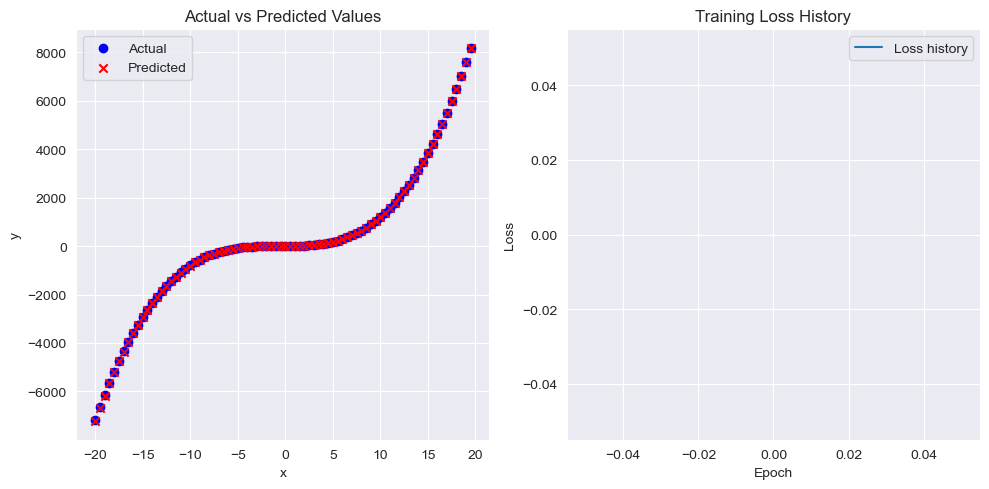

Some actual vs. predicted values:
tensor([[-7199.0000, -7224.3164],
        [-6653.3750, -6692.4097],
        [-6136.0000, -6169.3755],
        [-5646.1250, -5666.7861],
        [-5183.0000, -5202.0269]])


In [131]:
from torch import autocast
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
logdir = "runs"
tf.debugging.experimental.enable_dump_debug_info(logdir, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)
torch.set_default_dtype(torch.float32)
class NN(nn.Module):
    def __init__(self, input_dim, output_dim, mode=0):
        super(NN, self).__init__()
        self.mode = mode
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.model_path = None

        if self.mode == 0:
            self.model_path = f"model/NN-mode-{self.mode}-{self.input_dim}-{self.output_dim}.pt"
            self.layers = nn.Sequential(
                nn.Linear(input_dim, 610),
                nn.SELU(),
                nn.Linear(610, 377),
                nn.SELU(),
                nn.Linear(377, 144),
                nn.SELU(),
                nn.Linear(144, 233),
                nn.SELU(),
                nn.Linear(233, output_dim),
                nn.Softmax(dim=1)
            )
            self.optimizer = optim.Adam(self.parameters(), lr=0.001)  # Assuming a learning rate is defined

        elif self.mode == 1:
            # Dummy behavior for random output, could be designed better based on specific requirements
            self.layers = None
    #@autocast(device_type=torch.get_default_device())
    def forward(self, x):
        if self.mode == 0:
            return self.layers(x)
        elif self.mode == 1:
            return torch.rand((x.shape[0], self.output_dim))  # Random tensor with the same batch size as input

    def save_model(self):
        filename = f"NN-mode-{self.mode}-{self.input_dim}-{self.output_dim}.pt"
        # Saving as TorchScript
        model_scripted = torch.jit.script(self)
        model_scripted.save(filename)
        print(f"Model saved as {filename}")

    def load_model(self, filepath):
        model_loaded = torch.jit.load(self.model_path)
        print(f"Model loaded from {filepath}")
        return model_loaded
    
class TrainingEnvironment:
    def __init__(self, model, learning_rate=1):
        self.model = model
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_history = []
        self.writer = SummaryWriter()  # Initializing TensorBoard

    def train(self, data_generator, epochs):
        x, y_true = data_generator.get_data()
        for epoch in range(epochs):
            y_pred = self.model(x)
            loss = self.criterion(y_pred, y_true)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch == 0:  # Log the model graph only once
                self.writer.add_graph(self.model, x)
                
            if (epoch+1) % 100 == 0:
                self.writer.add_scalar('Loss/train', loss.item(), epoch)
                for name, param in self.model.named_parameters():
                    self.writer.add_histogram(name, param, epoch)
                
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    def evaluate(self, data_generator):
        self.model.eval()
        x, y_true = data_generator.get_data()
        with torch.no_grad():
            y_pred = self.model(x)
        self.writer.add_graph(self.model, x)  # Log the model graph
        return y_pred
    
class DataGenerator:
    def __init__(self):
        self.x = torch.arange(-20, 20, 0.5).unsqueeze(1)
        self.y_true = self.x * self.x * self.x + 2 * self.x * self.x + 1  # y = 2x + 1

    def get_data(self):
        return self.x, self.y_true

def plot_results(model, data_generator, training_environment):
    x, y_true = data_generator.get_data()

    model.eval()
    with torch.no_grad():
        y_pred = model(x)

    # Plotting actual vs predicted values
    plt.figure(figsize=(10, 5))

    # Subplot for the regression line
    plt.subplot(1, 2, 1)
    plt.scatter(x.numpy(), y_true.numpy(), color='blue', label='Actual')
    plt.scatter(x.numpy(), y_pred.numpy(), color='red', marker='x', label='Predicted')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    # Subplot for the loss history
    plt.subplot(1, 2, 2)
    plt.plot(training_environment.loss_history, label='Loss history')
    plt.title('Training Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Instantiate the classes
policy = NN(input_dim=1, output_dim=1)
data_generator = DataGenerator()
training_environment = TrainingEnvironment(model=policy, learning_rate=0.003)

# Train the model
training_environment.train(data_generator, epochs=5000)

# Evaluate the model
policy.eval()
plot_results(policy, data_generator, training_environment)
with torch.no_grad():
    x, y_true = data_generator.get_data()
    y_pred = policy(x)
    print("Some actual vs. predicted values:")
    print(torch.cat([y_true[:5], y_pred[:5]], 1))


In [146]:
policy(torch.tensor([1], dtype=torch.float32))

tensor([4.2234], grad_fn=<ViewBackward0>)

In [147]:
x = 1
x * x * x + 2 * x * x + 1

4

In [132]:
!tensorboard --logdir=runs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [69]:
import torch

class TensorUpdater:
    def __init__(self):
        # Define transitions
        self.transitions = {
            0: torch.tensor([2, 0, 0]),
            1: torch.tensor([-2, 0, 0]),
            2: torch.tensor([0, 2, 0]),
            3: torch.tensor([0, -2, 0]),
            4: torch.tensor([0, 0, 2]),
            5: torch.tensor([0, 0, -2]),
            6: torch.tensor([1, 1, 0]),
            7: torch.tensor([1, -1, 0]),
            8: torch.tensor([1, 0, 1]),
            9: torch.tensor([1, 0, -1]),
            10: torch.tensor([-1, 1, 0]),
            11: torch.tensor([-1, -1, 0]),
            12: torch.tensor([-1, 0, 1]),
            13: torch.tensor([-1, 0, -1]),
            14: torch.tensor([0, 0, 0])
        }
        # Initialize some example 3D tensor
        self.data = torch.arange(1000).view(10, 10, 10)  # Example tensor filled with values
        # Starting index as a tuple
        self.current_position = torch.tensor([5, 5, 5], dtype=torch.int64)

    def get_element_at_position(self, action):
        # Get transition based on agent's action
        transition = self.transitions[action]
        # Update the current position
        self.current_position += transition
        print(self.current_position)
        # Ensure the position does not go out of bounds
        self.current_position = torch.clamp(self.current_position, 0, 9)
        # Return the tensor element at the new position
        element = self.env.get_cell(self.current_position)
        return element

# Example usage
updater = TensorUpdater()
action = 0  # Agent's response, for example
element_at_new_position = updater.get_element_at_position(action)
print(f"Element at the new position: {element_at_new_position}")


tensor([7, 5, 5])
Element at the new position: 755


In [70]:
action = 13  # Agent's response, for example
element_at_new_position = updater.get_element_at_position(action)
print(f"Element at the new position: {element_at_new_position}")

tensor([6, 5, 4])
Element at the new position: 654


In [83]:
import torch

class MyClass:
    def __init__(self, tensor_dimensions):
        # Create a tensor with specified dimensions filled with random values
        self.tensor = torch.rand(*tensor_dimensions)
        # Define transitions; the dimensionality of the transitions should match the tensor
        # Here we define a simple example which works only for 3-dimensional tensors,
        # You should adjust or dynamically generate this based on tensor_dimensions.
        self.transitions = torch.tensor([
            [2, 0, 0],
            [-2, 0, 0],
            [0, 2, 0],
            [0, -2, 0],
            [0, 0, 2],
            [0, 0, -2],
            [1, 1, 0],
            [1, -1, 0],
            [1, 0, 1],
            [1, 0, -1],
            [-1, 1, 0],
            [-1, -1, 0],
            [-1, 0, 1],
            [-1, 0, -1],
            [0, 1, 1],
            [0, -1, -1],
            [0, 0, 0]
        ])

    def area(self, location):
        # Ensure location is a tensor and matches the tensor dimensions
        location = torch.tensor(location, dtype=torch.int64)
        # Add location to each transition to get a new set of locations
        new_locations = self.transitions + location[None, :]
        # Call _get_cell vectorized
        return self._get_cell(new_locations)

    def _get_cell(self, locations):
        # Clamp each dimension of locations to be within the tensor dimensions
        clamped_locations = torch.stack([
            torch.clamp(locations[:, i], 0, self.tensor.size(i) - 1) for i in range(self.tensor.dim())
        ], dim=1)
        # Use advanced indexing to retrieve multiple values from self.tensor
        return self.tensor[tuple(clamped_locations.t())]

# Example usage for a 3-dimensional tensor
mc = MyClass([10, 10, 10])  # Specify the dimensions of the tensor
print(mc.area([0, 0, 0]))  # Example location in the middle of the tensor


tensor([0.5360, 0.2077, 0.1030, 0.2077, 0.9793, 0.2077, 0.4118, 0.4640, 0.9930,
        0.4640, 0.9501, 0.2077, 0.7424, 0.2077, 0.3062, 0.2077, 0.2077])


In [255]:
t = mc.area([0, 0, 0])
t.dtype

torch.float32

In [113]:
q = torch.tensor([0.38, 0.5, 0.62])
print(torch.quantile(t.flatten(), q))


tensor([0.2077, 0.3062, 0.4598])


In [256]:
q.dtype

torch.float32

In [115]:
t.max()

tensor(0.9930)

In [169]:
class Book:
    def __init__(self, title, author, pages):
        self.title = title
        self.author = author
        self.pages = pages
        
    def call(self):
        print(f"Hello Title: {self.title} by {self.author} with {self.pages} pages.")

library = [Book("Title1", "Author1", 100)]
library.append(Book("Title2", "Author2", 200))
library[0].call()
len(library)

Hello Title: Title1 by Author1 with 100 pages.


2

In [170]:
class Book:
    def __init__(self, title):
        self.title = title
    
    def display_title(self):
        print(f"Title: {self.title}")

class BookWrapper:
    def __init__(self, book):
        self.book_class = book

# Create instances of Book
book1 = Book("1984")
book2 = Book("Animal Farm")

# Wrap the books
wrapper1 = BookWrapper(book1)
wrapper2 = BookWrapper(book2)

# List of wrappers
wrapper_list = [wrapper1, wrapper2]

# Accessing and invoking a method on the second book
wrapper_list[1].book_class.display_title()


Title: Animal Farm


In [171]:
np.random.rand()

0.9017859978317155

In [203]:
import torch

# Assuming tensor_a is already defined with shape [21, 21, 21]
# Let's create an example tensor_a filled with random numbers for demonstration
tensor_a = torch.randn(7, 7, 7)
tensor_a

tensor([[[ 1.3086, -2.1367, -2.7246,  1.8213, -0.2939,  0.5400,  1.6807],
         [-1.6426,  0.6841, -1.1709, -1.5977,  0.1907,  0.5703, -2.6406],
         [ 0.6602, -1.5830, -1.0117,  0.5190, -0.3171,  1.8896,  0.1170],
         [-0.6250, -0.0053, -0.0861,  1.1572,  0.2900, -1.0039,  0.0696],
         [-1.6973, -1.3447,  1.5635,  1.4082,  1.0957,  1.6406, -0.5146],
         [-1.4082,  0.3250,  0.8818, -0.4639, -1.2051, -1.2266, -0.8672],
         [-0.3423, -0.8521, -0.5083, -0.7993,  0.5303,  0.0223, -2.4434]],

        [[-0.6064, -1.5674, -0.4419,  2.1484, -0.5503, -1.1348,  1.6973],
         [ 1.1748,  0.0481,  1.4922, -2.1309, -0.8799,  0.8813,  2.5371],
         [ 1.0029,  0.1901,  0.5576, -1.9775, -1.6904, -0.9150, -1.1367],
         [ 0.4387,  0.2761,  1.6631, -0.0712,  1.7197,  0.6440, -1.5117],
         [ 0.1643, -1.2305,  0.2035, -0.3157,  1.5898,  0.9927, -0.6313],
         [-0.0715,  0.6538,  0.4482,  0.5024,  0.1340,  0.4192, -0.6621],
         [ 0.6704, -0.2654, -0.3689,

In [204]:

# Define tensor_b
tensor_b = torch.tensor([8, 9, 10])

# Clamp the values in tensor_b to be within the indices range of tensor_a
# tensor_a.shape gives (21, 21, 21), so the maximum valid index is (20, 20, 20)
clamped_b = torch.clamp(tensor_b, 0, tensor_a.shape[0] - 1)
print(clamped_b)
# Access the element in tensor_a using the clamped indices
element = tensor_a[clamped_b[0], clamped_b[1], clamped_b[2]]

print("Element at clamped index:", element)


tensor([6, 6, 6])
Element at clamped index: tensor(1.4619)


In [ ]:
from random import shuffle

def find_next_valid_move(self, agent):
    terminate = False
    tested_indices = set()  # Track tested indices
    indices_pool = list(range(len(self.transitions)))  # List of all possible indices
    shuffle(indices_pool)  # Shuffle to randomize the initial order

    while not terminate and indices_pool:
        idx = indices_pool.pop()  # Select and remove the last element from the pool
        tested_indices.add(idx)
        next_position = self.transitions[idx] + agent.location[-1]  # Update the position based on the chosen transition

        if self.valid_env_move(newpos=next_position, agent=agent) and self.l(mode='hard', locations=next_position, intensity=0.99):
            agent.violations.append(self.env.get_cell(next_position))
            print("OBS.step: Hard Constraint Violation, seeding next valid move")
            terminate = True  # Valid move found, terminate while loop
        elif not indices_pool:  # If no indices left, all possibilities have been tested
            print("No valid moves left to test.")
            terminate = True  # Could also handle reinitialization or error handling here

    if not terminate:
        # Handle the case where no valid move was found after testing all transitions
        print("All transitions tested, no valid move found.")

    return terminate


In [4]:
import torch

def l(context, loc, intensity):
    # Dummy implementation for the l() function
    # This should be replaced with the actual implementation
    # Assuming it returns a negative value based on the state's undesirability
    if context == 'soft':
        #return -intensity * torch.norm(loc)  # Dummy calculation
        print(intensity)
        return -1
    return 0

def reward(agent, loc, cell, invalid=False, slip_roll=False, death=False):
    energy, risk, wall, death_state, m = cell
    end_pos = torch.tensor([9, 9])  # Example end position
    penalty = -m + l('soft', loc, intensity=0.99)  # default penalty calculation
    
    # Apply the penalty adjustments based on conditions
    if invalid:
        penalty *= 3  # Triple the penalty if the action was invalid
    if slip_roll:
        penalty *= 1.6  # Increase the penalty by 60% if a slip occurred
    if death or death_state:
        penalty *= 4  # Quadruple the penalty if death occurred

    # Check if the agent reached the end position
    if torch.equal(end_pos, loc):
        # Reward the agent based on reaching the target and the safety of the path
        penalty = -5 * penalty  # Positive reward, 5 times the negated penalty

        # Calculate distance to end position and apply a logarithmic scale discount
        distance_to_end = torch.norm(end_pos - loc)
        #max_distance = 2 * torch.prod(self.env.sz_tensor).item()
        max_distance = 2 * torch.prod(torch.tensor([10, 10])).item()
        discount_factor = torch.log1p(distance_to_end / max_distance)
        discount = torch.clamp(discount_factor, max=0.5)
        penalty *= (1 - discount)  # Apply discount to the reward

    return penalty

# Example usage:
# Define the environment size and agent position
env_sz_tensor = torch.tensor([10, 10])  # Example environment size
agent = end_pos = torch.tensor([9, 9])
loc = torch.tensor([9, 9])  # Location of the agent
cell = (0.5, 0.1, 0, False, 0.2)  # Example cell properties (energy, risk, wall, death, map value)

# Call the reward function
reward_val = reward(agent, loc, cell, invalid=False, slip_roll=True, death=False)
print(f"Reward: {reward_val}")


0.99


RuntimeError: linalg.vector_norm: Expected a floating point or complex tensor as input. Got Long

In [5]:
import torch
import numpy as np

def step(self, agent, action, safety=True, is_slip_activated=True):
    """Performs a step in the environment based on the agent's action."""
    penalty = 0
    terminate = False
    roll = False  # Default roll value

    # Calculate next position based on the action
    next_position = self.transitions[action] + torch.as_tensor(agent.location[-1])
    valid = self.valid_env_move(newpos=next_position, agent=agent)

    if not valid:
        agent.violations.append((self.env.get_cell(next_position), next_position))
        print("OBS.step: Invalid Move")
        terminate = True
        return (
            self.reward(agent=agent, loc=next_position, cell=self.env.get_cell(next_position), invalid=True),
            self.observation(next_position, agent.end, agent.team),
            next_position, terminate
        )

    # Apply slip effect if activated
    if is_slip_activated:
        roll, risk = self.env.roll(next_position)
        if roll:
            old_position = next_position
            next_position = self.transitions[np.random.randint(len(self.transitions))] + torch.as_tensor(agent.location[-1])
            valid = self.valid_env_move(newpos=next_position, agent=agent)

            if not valid:
                agent.violations.append((self.env.get_cell(next_position), next_position))
                print("OBS.step.slipped: Invalid Move")
                terminate = True
                return (
                    self.reward(agent=agent, loc=next_position, cell=self.env.get_cell(next_position), invalid=True),
                    self.observation(next_position, agent.end, agent.team),
                    next_position, terminate
                )

    # Enforce hard safety constraints if safety is enabled
    if safety and self.l(mode='hard', locations=next_position, intensity=0.99):
        agent.violations.append((self.env.get_cell(next_position), next_position))
        print("OBS.step: Hard Constraint Violation")
        terminate = True  # Terminate if hard constraints are violated
        next_position = self.find_safe_position(agent)

    reward = self.reward(agent, next_position, self.env.get_cell(next_position), invalid=terminate, slip_roll=roll)
    next_observation = self.observation(next_position, agent.end, agent.team)
    print("OBS.step.reward: ", reward)

    return reward, next_observation, next_position, terminate

def find_safe_position(self, agent):
    """Finds a safe position starting from the last known valid position of the agent."""
    for index in np.random.permutation(len(self.transitions)):
        potential_pos = self.transitions[index] + torch.as_tensor(agent.location[-1])
        if self.valid_env_move(newpos=potential_pos, agent=agent) and not self.l(mode='hard', locations=potential_pos, intensity=0.99):
            print(f"Valid move found at index {index}, position {potential_pos}")
            return potential_pos

    print("OBS.step.l.seed: No valid moves found.")
    return agent.location[-1]  # Return to the last valid position if no valid move is found
